<a href="https://colab.research.google.com/github/yvessong23/ML-TEAM-15/blob/main/BinBuddiesCNNBaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import TensorFlow
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns

In [ ]:
%pip install numpy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import hashlib, os
from PIL import Image
%pip install kagglehub

import kagglehub

# Download latest version
path = kagglehub.dataset_download("zlatan599/garbage-dataset-classification")
rgb_path = "cleaned/garbage-dataset-rgb"
print("Path to dataset files:", path)

hashes = {}
duplicates = []

def file_hash(filePath):
    with open(filePath, "rb") as f: # Open and read files for hashing
        file_bytes = f.read()
        return hashlib.md5(file_bytes).hexdigest()

for root, dirs, files in os.walk(path):
    for file in files:
        file_path = os.path.join(root, file)
        h = file_hash(file_path)

        if h in hashes:
            print(f"Duplicate found! Removing {file_path} (same as {hashes[h]})")
            try:
                os.remove(file_path)
                duplicates.append((file_path, hashes[h]))
            except OSError as e:
                print(f"Warning: Could not remove {file_path} due to read-only filesystem. Error: {e}")
        else:
            hashes[h] = file_path
            try:
                # Preserve the dataset’s subfolder structure
                rel_dir = os.path.relpath(root, path)
                save_dir = os.path.join(rgb_path, rel_dir)
                os.makedirs(save_dir, exist_ok=True)

                save_path = os.path.join(save_dir, file)

                # Skip non-image files (like metadata.csv)
                if not file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff")):
                    continue

                with Image.open(file_path) as img:
                    img.convert("RGB").save(save_path)

            except Exception as e:
                print(f"Error processing {file_path}: {e}")

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

rgb_path = "cleaned/garbage-dataset-rgb"
base_path = os.path.join(rgb_path, "Garbage_Dataset_Classification", "images")
DATASET_DIR = base_path

# Set up class names
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
num_classes = len(class_names)

if 'duplicates' not in globals():
    duplicates = []

# Verify and collect all image paths and their labels
image_paths = []
labels = []

duplicate_filepaths = {f[0] for f in duplicates} # Extract only the file paths from the duplicates list

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(base_path, class_name)
    if os.path.exists(class_dir):
        class_images = [f for f in os.listdir(class_dir)
                       if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
        print(f"{class_name}: {len(class_images)} images")

        for img_file in class_images:
            full_path = os.path.join(class_dir, img_file)
            if full_path not in duplicate_filepaths: # Only add if not a duplicate
                image_paths.append(full_path)
                labels.append(class_idx)
    else:
        print(f"Warning: {class_dir} does not exist")

cardboard: 1718 images
glass: 2293 images
metal: 1628 images
paper: 1809 images
plastic: 1709 images
trash: 2500 images


In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
import numpy as np

# image sizes
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_SIZE   = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 32

# training data
# rescales pixel values to [0,1]
# uses 70% of data as training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

# validation data
# will split into val/test sets later with a 50/50 split
val_test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Load all validation images into memory, then split into val + test
val_generator_full = val_test_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

val_data = []
val_labels = []

for i in range(len(val_generator_full)):
    x, y = val_generator_full[i]
    val_data.append(x[0])
    val_labels.append(y[0])

val_data = np.array(val_data)
val_labels = np.array(val_labels)

# split loaded validation set into 50 val/50 test
# stratify ensures class balance in each split
X_val, X_test, y_val, y_test = train_test_split(
    val_data,
    val_labels,
    test_size=0.5,
    random_state=42,
    stratify=np.argmax(val_labels, axis=1)
)

val_generator_data = (X_val, y_val)
test_generator_data = (X_test, y_test)

# CNN WITH GLOBAL AVERAGE POOLING
# VGG-style architecture with:
#  Convolutional blocks
#  Batch Normalization for stability
#  MaxPooling for spatial reduction
#  L2 regularization to reduce overfitting
#  GAP head instead of Flatten
model_gap = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # Block 1
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(2),

    # Block 2
    layers.Conv2D(128, (5,5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(2),

    # Block 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPool2D(2),

    # Block 4
   layers.Conv2D(512, (3,3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPool2D(2),

    # Head with GAP
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dense(6, activation='softmax'),
])


Found 8163 images belonging to 6 classes.
Found 2328 images belonging to 6 classes.


# Testing CNN with Global Average Pooling

Using ChatGPT and Kaggle, I found that GAP or Global Average Pooling can significantly reduce the number of parameters. This method compresses each feature map into a single value by averaging its activations (outputs). This reduced our dimensionality from 34+ million to about 1.8M. This also allows the model to generalize better and train faster.
https://www.kaggle.com/code/faressayah/cifar-10-images-classification-using-cnns-88
https://www.kaggle.com/code/zlatan599/f1-0-97-garbage-classif-final-version-2

The baseline run of this model with no dropout, data augmentation, or hyperparameter tuning was:

* Train Accuracy: 0.5875

* Train Loss: 1.3597

* Best Validation Accuracy: 0.4210 (Epoch 7)

* Best Validation Loss: 1.7832 (Epoch 7)

* Test Accuracy:: 0.4261

* Test Loss: 1.8093

In [ ]:
print(tf.config.list_physical_devices("GPU"))

model_gap.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_gap.summary()

# early stopping stops training if validation loss doesn't improve.
# makes training time faster
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# save best model for test set
checkpoint = ModelCheckpoint(
    'best_model_gap.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# train model
history_gap = model_gap.fit(
    train_generator,
    validation_data=val_generator_data,
    epochs=30,
    callbacks=[early_stopping, checkpoint]
)

#
test_loss, test_acc = model_gap.evaluate(
    X_test,
    y_test,
    batch_size=BATCH_SIZE,
    verbose=2
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,837,382 (7.01 MB)

 Trainable params: 1,834,950 (7.00 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.3886 - loss: 8.0374
Epoch 1: val_loss improved from inf to 3.48668, saving model to best_model_gap.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 96s 266ms/step - accuracy: 0.3887 - loss: 8.0286 - val_accuracy: 0.2311 - val_loss: 3.4867
Epoch 2/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.4538 - loss: 2.3921
Epoch 2: val_loss improved from 3.48668 to 2.43380, saving model to best_model_gap.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 48s 186ms/step - accuracy: 0.4538 - loss: 2.3911 - val_accuracy: 0.2285 - val_loss: 2.4338
Epoch 3/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.4706 - loss: 1.7441
Epoch 3: val_loss did not improve from 2.43380
256/256 ━━━━━━━━━━━━━━━━━━━━ 47s 184ms/step - accuracy: 0.4706 - loss: 1.7440 - val_accuracy: 0.2225 - val_loss: 2.5653
Epoch 4/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.4742 - loss: 1.6284
Epoch 4: val_loss did not improve from 2.43380
256/256 ━━━━━━━━━━━━━━━━━━━━ 47

Model Evaluation at baseline


---

GAP head

In [ ]:
# load best model and predict with test data
best_model = tf.keras.models.load_model("best_model_gap.keras")

test_images, test_labels = test_generator_data

y_probs = best_model.predict(test_images)

y_pred = np.argmax(y_probs, axis=1)
y_true = np.argmax(test_labels, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.57      0.52      0.54       172
       glass       0.37      0.76      0.50       229
       metal       0.54      0.12      0.19       162
       paper       0.50      0.24      0.33       181
     plastic       0.39      0.54      0.45       170
       trash       0.42      0.32      0.36       250

    accuracy                           0.43      1164
   macro avg       0.47      0.41      0.40      1164
weighted avg       0.46      0.43      0.40      1164



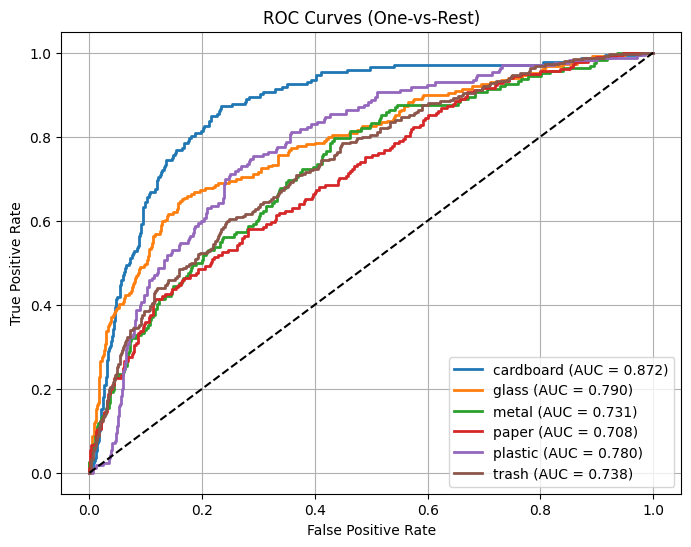

In [ ]:
# ROC Curves

from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{class_name} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

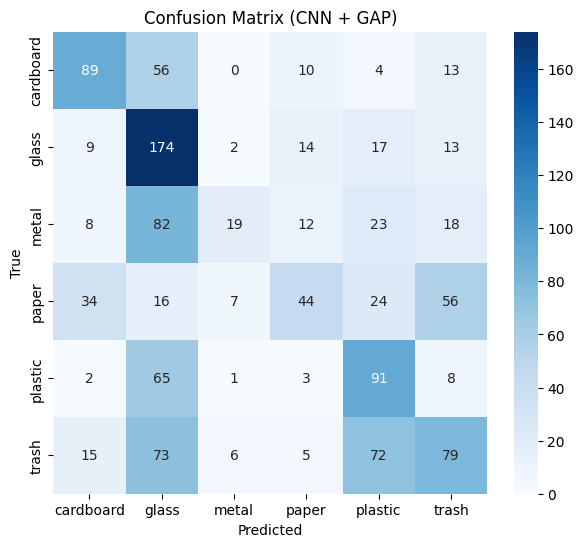

In [ ]:
# Confusion Matrix Visualization

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix (CNN + GAP)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()